# MMM Toy Data Set: Two Variables - Balanced Spend

* Create a toy data set to explore relationships in Robyn
* Data set should include pre-Robyn window period to avoid cold start and take advantage of how Robyn uses data outside the window to estimate carryover marketing effects going into the first window day.
* Note: Balanced spend means that the relationship between spend and bookings is identical for each variable, so decomp.rssd minimization is perfectly congruent with the correct answer.  In some ways this is "too easy" a test case, but a good starting point

In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
np.random.seed(43)

bookings_columns = ['bookings_noiseless', 'bookings_noisy', 'bookings_noisy_context']

#
# data set has no lag effect from media at all here
#
for stderr in [600000]:
    print(f'Creating data set with stderr {stderr}')
    df = pd.DataFrame({'date':pd.date_range(start='2015-01-01', end='2021-12-31')})

    # marketing effort
    #
    # random tv marketing from 0 to 10000 each period
    # marketing has a $0 floor on TV spend
    df['tv'] = np.random.randint(0, 10000, size=len(df))
    
    # random fb spend, minimum threshold fb_daily_min each period
    # Marketing has both a non-zero floor and a ceiling on how much to sepend on FB
    fb_daily_min = 2500
    df['fb'] = np.random.randint(0, 5000, size=len(df)) + fb_daily_min
    
    # context variables for testing 
    df['context_0_center'] = np.random.normal( size=len(df))
    df['context_100_center'] = 100 + df.context_0_center
    
    
    fixed_bookings = 10000000
    tv_scale = 200
    fb_scale = 200
    context_scale = 800000
    
    #
    # But bookings are still driven by a fixed amount (call that business momentum) plus an effect which is linear in TV and FB
    #
    df['fb_contribution'] = df.fb * fb_scale
    df['tv_contribution'] = df.tv * tv_scale
    df['bookings_noiseless'] = fixed_bookings + df.tv_contribution + df.fb_contribution
    df['bookings_noisy'] = df.bookings_noiseless + np.random.normal(loc=0, scale=stderr, size=len(df)) 
    
    # we use this whether predicting with context_0_center or context_100_center.  Those are two different forms of describing the same context
    df['bookings_noisy_context'] = df.bookings_noisy + df.context_0_center * context_scale
    
    for i in bookings_columns:
        print(f'Checking {i} for negative values')
        assert len(df[df[i]<0]) == 0, f'{i} has negative values which is not permitted'
    
    df.to_csv(os.path.join('data', f'robyn_toy_data_2paidvar_balanced_{stderr}err.csv'), index=False)


Creating data set with stderr 600000
Checking bookings_noiseless for negative values
Checking bookings_noisy for negative values
Checking bookings_noisy_context for negative values


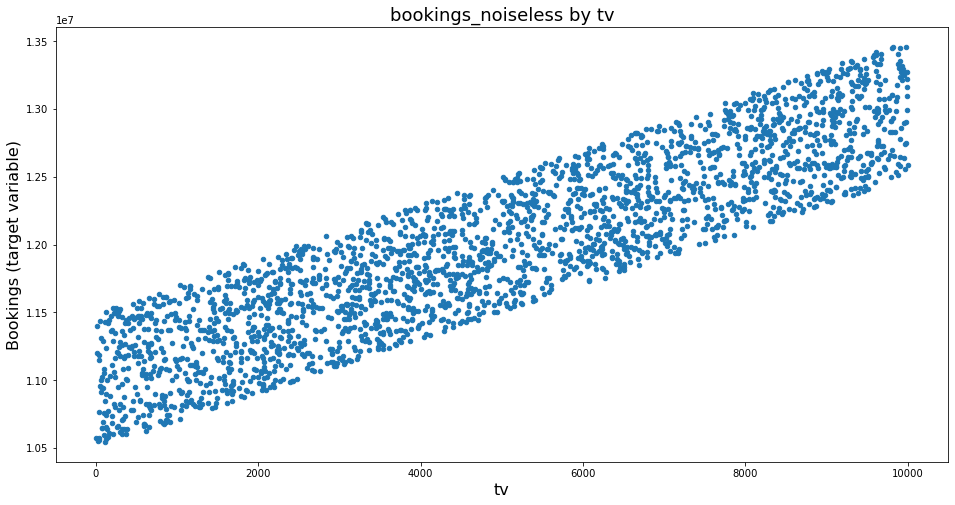

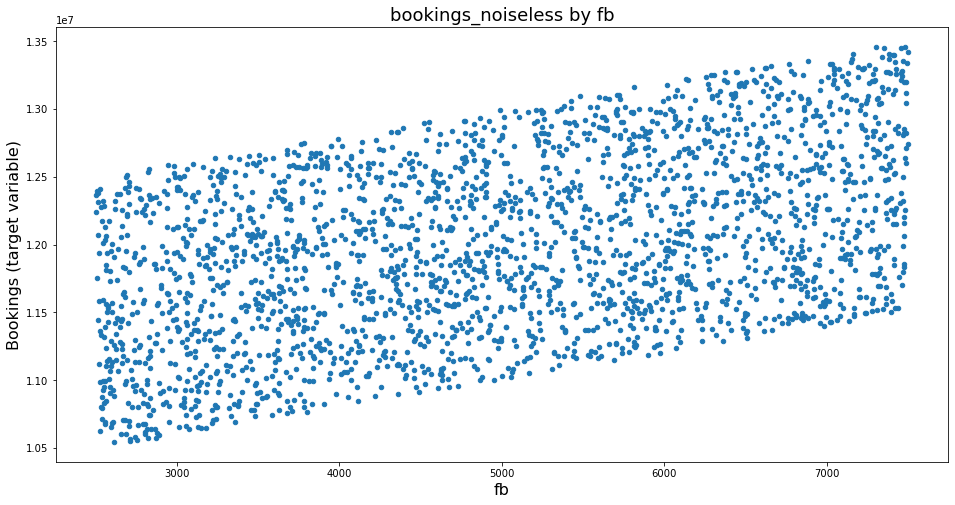

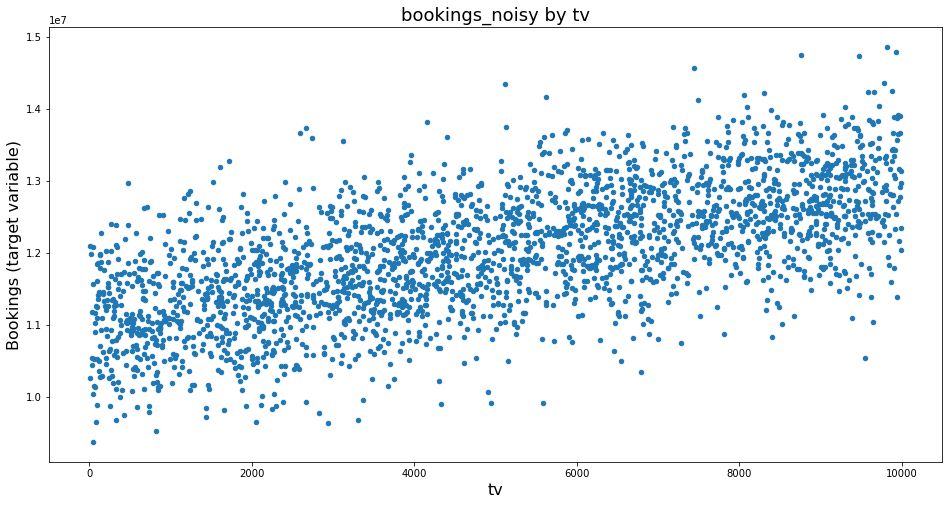

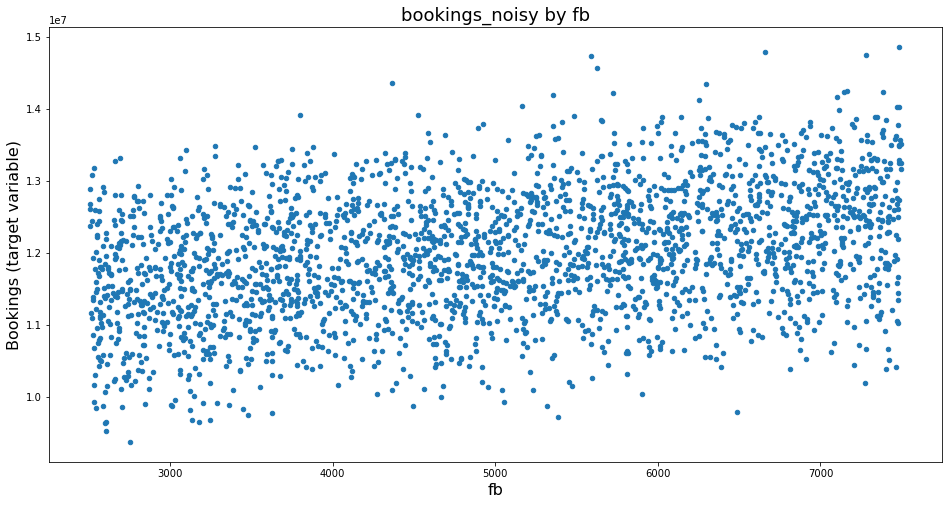

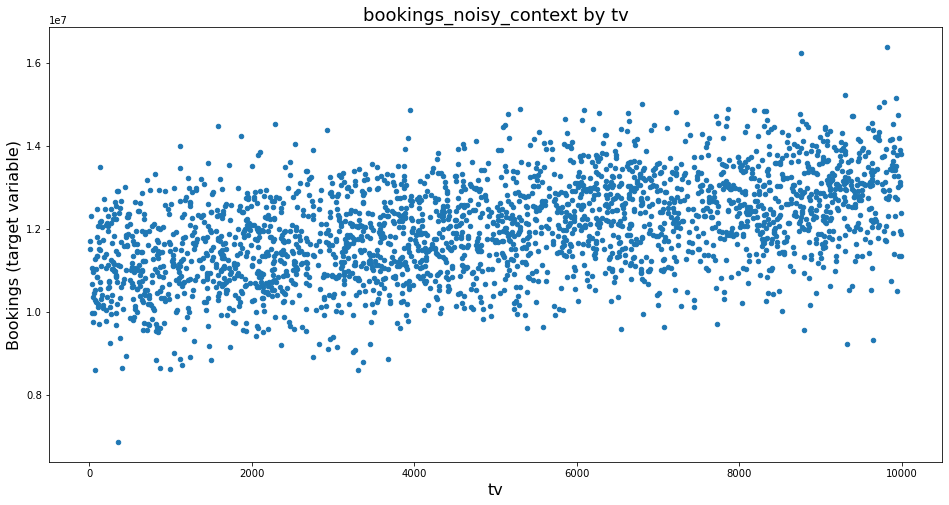

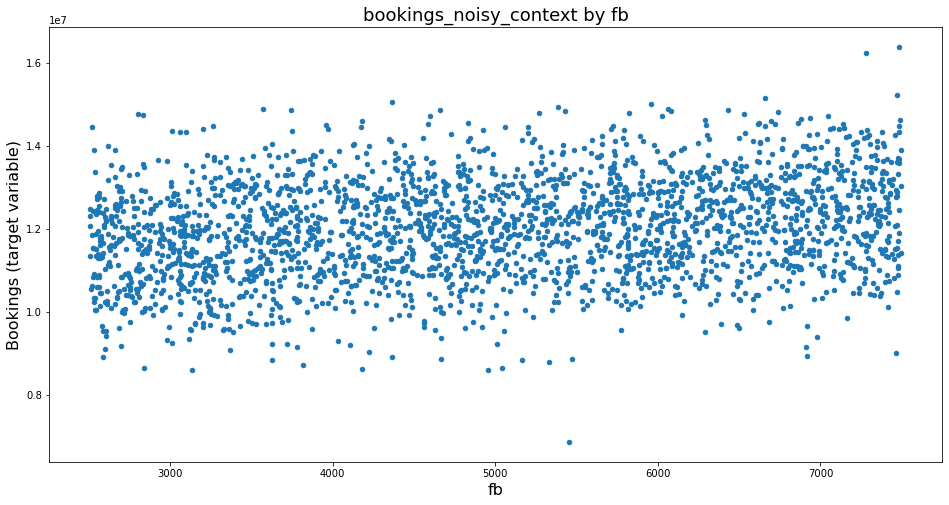

In [3]:
import matplotlib.pyplot as plt

for i in bookings_columns:
    for ivar in ['tv', 'fb']:
        ax = df.plot.scatter(y=i, x=ivar, figsize=(16,8))
        ax.set_title(f'{i} by {ivar}', fontsize=18)
        ax.set_ylabel('Bookings (target variable)', fontsize=16)
        ax.set_xlabel(ivar, fontsize=16)
        plt.show()

In [4]:
for i in bookings_columns:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

bookings_noiseless: mean 11993780 and stddev 647813
bookings_noisy: mean 11992743 and stddev 874341
bookings_noisy_context: mean 12007874 and stddev 1176310


In [5]:
for i in ['fb', 'tv']:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

fb: mean 4996 and stddev 1459
tv: mean 4973 and stddev 2858


## Checking the correct answer in Robyn for 2021 Window

In [6]:
df2021 = df[df['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
len(df2021)

365

In [7]:
df2021.fb_contribution.sum()

359515200

In [8]:
df2021.tv_contribution.sum()

362187000

### Note: The FB spend varies between a min and max, but should still be distinguishable by Robyn

In [9]:
df2021.bookings_noiseless.sum()

4371702200

In [10]:
# prove the math that we assume takes place here
df2021.bookings_noiseless.sum() - df2021.fb_contribution.sum() - df2021.tv_contribution.sum() - len(df2021) * fixed_bookings

0

## Spend Proportion in this data set

* Note: this data set has spend portion very different from impact portion
* So robyn's minimization of decomp.RSSD will balance against NRMSE

In [11]:
aggs = {
    'fb': 'sum',
    'tv': 'sum'
}
spend_portion = df2021.agg(aggs).reset_index()
spend_portion.rename(columns={'index': 'spend_type', 0: 'spend_amt'}, inplace=True)
spend_portion['percent_of_spend'] = (spend_portion['spend_amt'] / spend_portion['spend_amt'].sum()) * 100
spend_portion

,spend_type,spend_amt,percent_of_spend
0,fb,1797576,49.814896
1,tv,1810935,50.185104
